# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [69]:
import torch
import torchvision
import torchvision.transforms as transforms
from matplotlib import pyplot as plt
from torch import nn
from torch.optim import SGD
import numpy as np

In [70]:
import os
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [71]:
transform = transforms.ToTensor()

trainset = torchvision.datasets.MNIST(root='./data',train=True,download=True,transform=transform)
testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

[MY CODE] trainset 와 testset  한데 모음

MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

60000
torch.Size([1, 28, 28]) 5


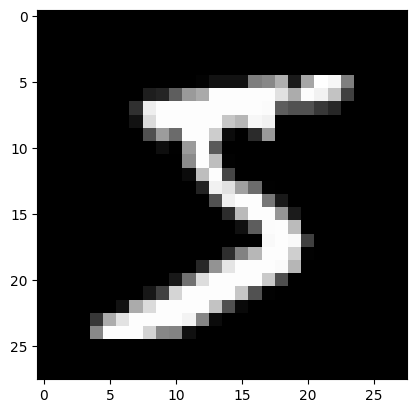

In [72]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [73]:
batch_size = 256

trainloader = torch.utils.data.DataLoader(trainset,batch_size=batch_size,shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [74]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 1, 28, 28]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [75]:
from torch import nn


class SimpleANN(nn.Module):
  def __init__(self, input_dim, n_dim):
    super().__init__()

    self.layer1 = nn.Linear(input_dim, n_dim)
    self.layer2 = nn.Linear(n_dim, n_dim)
    self.layer3 = nn.Linear(n_dim, 10) #  손실함수 MSE로 부터 nn.CrossEntropyLoss() 바꾼다음,   Praramiter를 1로부터 10 바꿔야만 했음,  그렇치 않으면 오류 발생   nn.Linear(n_dim, 10)

    self.act = nn.ReLU()

  def forward(self, x):
    x = torch.flatten(x, start_dim=1)
    x = self.act(self.layer1(x))
    x = self.act(self.layer2(x))
    x = self.act(self.layer3(x))

    return x

model = None;
model = SimpleANN(28 * 28 * 1, 1024)

[MY CODE] self.layer3 = nn.Linear(n_dim, 10)   
손실함수 MSE로 부터 nn.CrossEntropyLoss() 바꾼다음,   Praramiter를 1로부터 10 바꿔야만 했음,  그렇치 않으면 오류 발생   nn.Linear(n_dim, 10)
하지만 원리의 구분에 대해서 아직 잘 모르겠습니다.

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [76]:
from torch.optim import SGD

lr = 0.001
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)
print(device)
optimizer = SGD(model.parameters(), lr=lr, momentum=0.9)

cpu


이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [77]:
def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in trainloader:
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [78]:
n_epochs = 100
train_accs = []  # 트레이닝 정확도 리스트
test_accs = []   # 테스트 정확도 리스트

criterion = nn.CrossEntropyLoss()
for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in trainloader:
    #model.zero_grad()
    optimizer.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    preds = model(inputs)
    #loss = (preds[:, 0] - labels).pow(2).mean()
    loss = criterion(preds, labels)

    loss.backward()
    optimizer.step()

    total_loss += loss.item()
  model.eval()
  train_acc = accuracy(model, trainloader)
  test_acc = accuracy(model, testloader)

  train_accs.append(train_acc)
  test_accs.append(test_acc)

  print(f"Epoch {epoch:3d} | Loss: {total_loss} | train_acc: {train_acc} | test_acc: {test_acc}"  )

Epoch   0 | Loss: 528.6091248989105 | train_acc: 0.5883833333333334 | test_acc: 0.5883833333333334
Epoch   1 | Loss: 467.0805026292801 | train_acc: 0.6339 | test_acc: 0.6339
Epoch   2 | Loss: 322.9093528389931 | train_acc: 0.7529833333333333 | test_acc: 0.7529833333333333
Epoch   3 | Loss: 195.9341766834259 | train_acc: 0.8312833333333334 | test_acc: 0.8312833333333334
Epoch   4 | Loss: 143.55190905928612 | train_acc: 0.857 | test_acc: 0.857
Epoch   5 | Loss: 119.68079087138176 | train_acc: 0.8735333333333334 | test_acc: 0.8735333333333334
Epoch   6 | Loss: 106.0373565852642 | train_acc: 0.8841333333333333 | test_acc: 0.8841333333333333
Epoch   7 | Loss: 97.1607977449894 | train_acc: 0.89085 | test_acc: 0.89085
Epoch   8 | Loss: 91.02327486872673 | train_acc: 0.8957166666666667 | test_acc: 0.8957166666666667
Epoch   9 | Loss: 86.3941148519516 | train_acc: 0.8986833333333333 | test_acc: 0.8986833333333333
Epoch  10 | Loss: 82.77879244089127 | train_acc: 0.9030166666666667 | test_acc: 0.

##[FEEDBACK] 위에서 보시면 Training 데이터와  Test 데이터가 너무 똑같은데 정상일가요, 이럴수가 없을텐데,  어디가 잘못된거죠?  어떻게 개산해야 할가요?

출력 결과를 보면 잘 수렴하는 것을 볼 수 있습니다.
이전 구현과 다른 점은 다음 두 가지입니다.
- `for data in trainloader`를 통해 batch들을 iterate하면서 model을 학습합니다.
- `inputs, labels = inputs.to('cuda'), labels.to('cuda')`를 통해 model의 입력으로 들어가는 tensor들을 GPU로 보냅니다.

마지막으로 첫 번째 data에 대한 예측 결과를 살펴봅시다.

##[FEEDBACK] 모델 배포한 상태 및 예측값을  볼수가 있습니다.

In [80]:
idx = 123

x = trainset[idx][0][None]  # (1, 1, 28, 28)
x = x.to(device)

logits = model(x)

print(logits)
print("오리지널 데이터:",trainset[idx][1])
predicted_class = torch.argmax(logits, dim=1).item()
print("모델추출 데이터: ",predicted_class)


tensor([[ 2.6722,  0.0000,  4.4875,  3.6338,  0.0000,  2.2682,  0.0000, 13.6968,
          1.9213,  5.4490]], grad_fn=<ReluBackward0>)
오리지널 데이터: 7
모델추출 데이터:  7


여기서 idx를 조정하여 다른 data에 대한 출력 결과도 볼 수 있습니다.
예측 결과를 보시면 아직 성능이 그렇게 좋지 않은 것을 알 수 있습니다.

##[FEEDBACK]  Train data 예측과 테스트 예측 정확율이 너무 똑같은데,  이럴수가 있을가요?

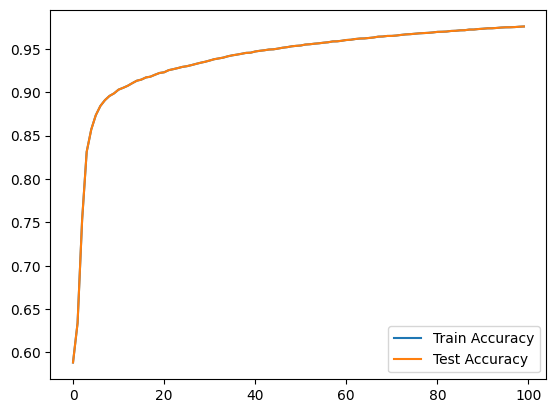

In [81]:
# Epoch에 따른 train과 test data에 대한 model의 정확도를 plot합니다
plot_acc(train_accs, test_accs, label1='Train Accuracy', label2='Test Accuracy')